3. Experiment Analysis

Q3: What is your hypothesis regarding the outcome? Please state both the null hypothesis (H0) and the alternative hypothesis (H1). For your alternative hypothesis, should it be one-tailed or two-tailed? Why?

Let $\mu_t$ be the average revenue per customer in the treatment variant and $\mu_c$ the same metric in the control variant.
- Null hypothesis ($H_0$): $\mu_t = \mu_c$
- Alternative hypothesis ($H_1$): $\mu_t \neq \mu_c$

The alternative hypothesis should be two-tailed because order bump may either hurt or help; there's no reason to lean one way or the other.

In [1]:
# handle data
import pandas as pd
import numpy as np

# visualize data
import seaborn as sns
import matplotlib.pyplot as plt

# run tests
from scipy import stats
import statsmodels.stats.api as sms

# aesthetics
sns.set(font_scale=2)
pd.options.mode.chained_assignment = None

In [2]:
# load all the data
df_pre = pd.read_csv('transactions_pre.csv')
df_post = pd.read_csv('transactions_post.csv')
df_meta = pd.read_csv('assignment.csv')

Q4: Does the data pass sanity checking? Please consider outliers, random assignments, pre-test differences between variants, and other factors you deem important.

1. Outliers

In [3]:
# pre-treatment summary statistics
df_pre['amount_usd'].describe()

count    443748.000000
mean         24.962695
std         950.452061
min           0.900000
25%           1.990000
50%           4.170000
75%          12.800000
max      109313.450000
Name: amount_usd, dtype: float64

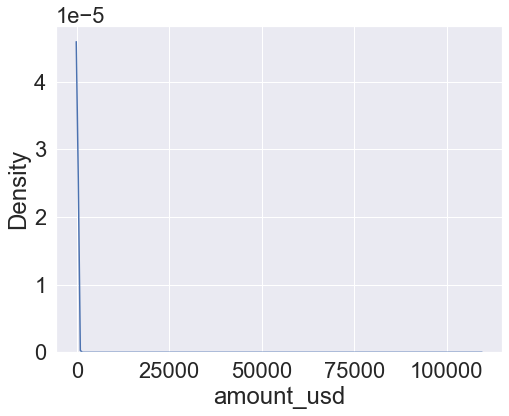

In [4]:
# plot the distribution
plt.figure(figsize=(8,6))
sns.kdeplot(data=df_pre, x='amount_usd')
plt.show()

In [5]:
# pre-treatment summary statistics
df_post['amount_usd'].describe()

count    398013.000000
mean         37.246828
std        1271.811492
min           0.900000
25%           2.130000
50%           5.550000
75%          17.310000
max      109954.310000
Name: amount_usd, dtype: float64

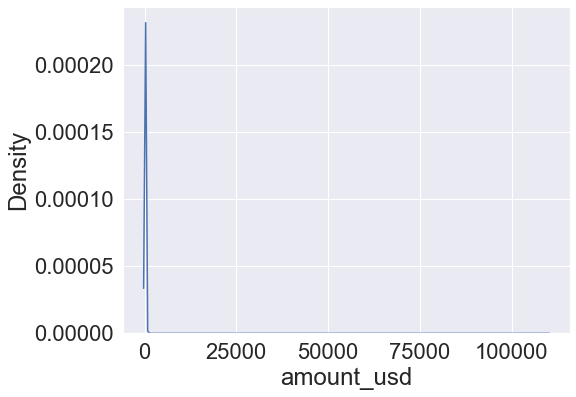

In [6]:
# plot the distribution
plt.figure(figsize=(8,6))
sns.kdeplot(data=df_post, x='amount_usd')
plt.show()

In [7]:
# Since not normally distributed, I'll first log transform 'amount_used' 
# and then remove transactions whose values are outside of the 99th percentile.
# find the cutoff for what counts as outliers
df_both = pd.concat([df_pre, df_post])
df_both['log_amount_usd'] = df_both['amount_usd'].apply(lambda x: np.log(x))
cutoff = df_both['log_amount_usd'].quantile(0.99)

In [8]:
def remove_outliers(df1, cutoff1):
    # log-transform transaction amount
    df1['log_amount_usd'] = df1['amount_usd'].apply(lambda x: np.log(x))
    
    # create a new dataframe without outliers
    df1_new = df1[df1['log_amount_usd'] <= cutoff1]
    
    # return new dataframe
    return df1_new

In [9]:
# remove outliers in both pre- and post-test data
df_pre_clean = remove_outliers(df_pre, cutoff)
df_post_clean = remove_outliers(df_post, cutoff)

In [10]:
# aggregate the data and calculate average revenue per user.
def aggregate_by_customer(df1):
    
    # get mean values for each customer
    revenue1 = df1.groupby('customer_id').mean().reset_index()
    
    # only select colums we need
    revenue1 = revenue1[['customer_id', 'amount_usd']]
    revenue1.rename(columns={'amount_usd': 'avg_revenue'}, inplace=True)
    
    # return new dataframe
    return revenue1

In [11]:
# aggregate in each period
agg_pre = aggregate_by_customer(df_pre_clean)
agg_post = aggregate_by_customer(df_post_clean)

2. Random assignments

In [12]:
# To check if assignment is random,i.e., throughout the experiment there should be the same number of units
# in each variant, we need to join the data first.
# left join data in each period
df = agg_pre.merge(agg_post, on='customer_id', how='left', suffixes=['_pre','_post'])
# if no transaction happened, treat the amount as 0
df.fillna(0, inplace=True)
# find the variant of each customer
df = df.merge(df_meta, on='customer_id')

In [13]:
# how many units are in each variant?
df.groupby('variant').size()

variant
control      9941
treatment    9921
dtype: int64

In [14]:
# The number is really close. We check sample ratio mismatch (SRM).
# null hypothesis: user ids are randomly assigned to control and treatment group;
# alternative hypothesis: not randomly assigned, sample ratio mismatch exists.
def check_srm(df1, alpha1):
    
    # sample size in each variant
    n_c1 = df1.groupby('variant').size()['control']
    n_t1 = df1.groupby('variant').size()['treatment']
    
    # 'success rate' (being assigned to treatment)
    p_t1 = n_t1 / (n_t1 + n_c1)
    
    # variance (Normal approximation of Binomial)
    var1 = 0.5 * (1 - 0.5)
    # standard error
    se1 = np.sqrt(var1 / (n_t1 + n_c1))
    
    # z-score
    z_score1 = (p_t1 - 0.5) / se1
    
    # p-value
    p_value1 = 1 - stats.norm.cdf(z_score1)
    
    # print result
    if p_value1 < alpha1:
        print(f'found sample ratio mismatch: p(treatment) = {p_t1}, p = {p_value1}')
    else:
        print(f'fail to reject random assignment hypothesis: p(treatment) = {p_t1}, p = {p_value1}')

In [15]:
# check for sample ratio mismatch
check_srm(df, 0.05)

fail to reject random assignment hypothesis: p(treatment) = 0.49949652602960426, p = 0.5564251629722654


3. Pre-test differences

In [16]:
# isolate pre_test data
treatment_pre = df[df['variant'] == 'treatment']['avg_revenue_pre']
control_pre = df[df['variant'] == 'control']['avg_revenue_pre']

In [21]:
treatment_pre.count()

9921

In [22]:
control_pre.count()

9941

In [23]:
# test for difference in treatment vs. control means
# average revenue per customer is already different in the pre-test period. 
# This is a strong indicator that customers are not randomly assigned to each variant.
stats.ttest_ind(treatment_pre, control_pre)

Ttest_indResult(statistic=-7.197679548774967, pvalue=6.342861266582803e-13)

In [24]:
# Because sample sizes are unequal, Welch's t-test is used.
stats.ttest_ind(treatment_pre, control_pre,equal_var=False)

Ttest_indResult(statistic=-7.199385813386023, pvalue=6.276155744168441e-13)

In [25]:
# impact of cutoff on pre-test difference
# removing cutoff from data makes the difference looks even bigger.
df_temp = aggregate_by_customer(df_pre).merge(df_meta, on='customer_id')
stats.ttest_ind(df_temp[df_temp['variant'] == 'treatment']['avg_revenue'], 
                df_temp[df_temp['variant'] == 'control']['avg_revenue'])

Ttest_indResult(statistic=-2.920747548398884, pvalue=0.0034958549725808458)

Q5: If variants were already different before the experiment, how would you analyze data more appropriately? (Hint: Instead of just comparing metric values in the post-test data, you can compute the post- vs. pre-test change for each customer and compare the average change between variants.)

In [26]:
# We can compute the change in each customer's average revenue. 
# If the treatment has an effect on customers' behavior, then the average change should be different 
# in each variant.
df['avg_rev_delta'] = df['avg_revenue_post'] - df['avg_revenue_pre']

Q6: Did order bump impact the metric you chose? What statistical tests did you conduct to answer this question? Were the assumptions behind them met? 

In [27]:
# isolate data for comparison
treatment = df[df['variant'] == 'treatment']['avg_rev_delta']
control = df[df['variant'] == 'control']['avg_rev_delta']

We can use a two-sample t-test to answer this question. Below are some basic assumptions behind t-test:
    - Independence between and within groups
    - Normality in each group
    - To pool variance, each group should have equal variance.

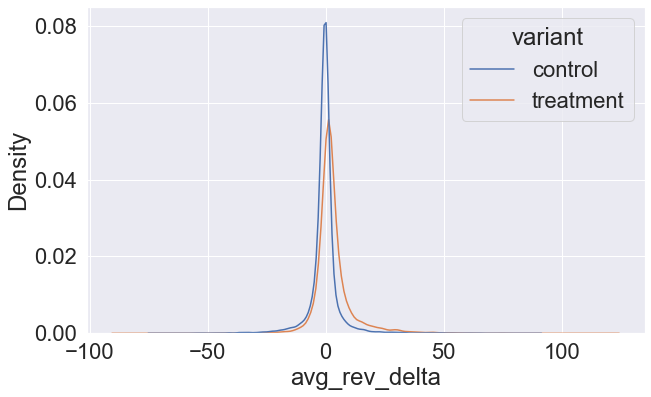

In [28]:
# plot the distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='avg_rev_delta', hue='variant')
plt.show()

In [29]:
def test_normality(data1, alpha1):
    # conduct normality test D'Agostino, R. B. (1971)
    ktwo1, p_value1 = stats.normaltest(data1)
    
    # print result
    # null hypothesis: data comes from a normal distribution
    if p_value1 < alpha1: 
        print("The data is NOT normally distributed :(")
    else:
        print("The data is normally distributed :)")

In [30]:
# test normality in each variant
test_normality(treatment, 0.05)
test_normality(control, 0.05)

The data is NOT normally distributed :(
The data is NOT normally distributed :(


In [32]:
treatment.count()

9921

In [33]:
control.count()

9941

In [34]:
# test for difference in treatment vs. control changes
# null hypothesis is rejected; change caused by order bump is statistically significant.
# since statistic(31) > 0, the change is positive.
stats.ttest_ind(treatment, control)

Ttest_indResult(statistic=31.208213551875527, pvalue=8.888175777344926e-209)

In [35]:
# Because sample sizes are unequal, Welch's t-test is used.
stats.ttest_ind(treatment, control,equal_var=False)

Ttest_indResult(statistic=31.20104453106611, pvalue=1.9905672123169906e-208)

In [36]:
# %95 CI
# The lower bound is greater than 0.
sms.CompareMeans(sms.DescrStatsW(treatment), sms.DescrStatsW(control)).tconfint_diff(usevar='unequal')

(3.200232388660616, 3.6292705515721653)

Keeping outliers will not change conclusions but reduces the variance of metric.

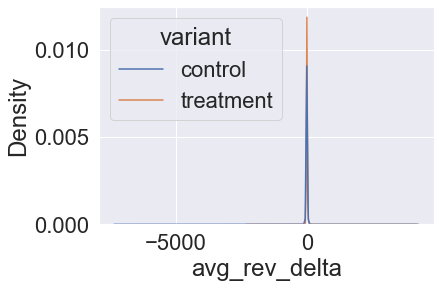

In [26]:
# 
agg_pre_nocutoff = aggregate_by_customer(df_pre)
agg_post_nocutoff = aggregate_by_customer(df_post)
df_nocutoff = agg_pre_nocutoff.merge(agg_post_nocutoff, on='customer_id', how='left', suffixes=['_pre','_post'])
df_nocutoff.fillna(0, inplace=True)
df_nocutoff = df_nocutoff.merge(df_meta, on='customer_id')
df_nocutoff['avg_rev_delta'] = df_nocutoff['avg_revenue_post'] - df_nocutoff['avg_revenue_pre']
treatment_nocutoff = df_nocutoff[df_nocutoff['variant'] == 'treatment']['avg_rev_delta']
control_nocutoff = df_nocutoff[df_nocutoff['variant'] == 'control']['avg_rev_delta']
sns.kdeplot(data=df_nocutoff, x='avg_rev_delta', hue='variant')
plt.show()

In [27]:
test_normality(treatment_nocutoff, 0.05)
test_normality(control_nocutoff, 0.05)

The data is NOT normally distributed :(
The data is NOT normally distributed :(


In [28]:
stats.ttest_ind(treatment_nocutoff, control_nocutoff)

Ttest_indResult(statistic=5.101778600554539, pvalue=3.395744989782546e-07)

In [29]:
sms.CompareMeans(sms.DescrStatsW(treatment_nocutoff), 
                 sms.DescrStatsW(control_nocutoff)).tconfint_diff(usevar='unequal')

(5.132733776112773, 11.533793441744976)